# Run LSTM Model<br>
Steps:<br>
1. Open dataset file
2. Run LSTM model
3. Save output into file

# 1. Open Dataset File

## Import libraries

In [1]:
# Import file and data libraries
import math
import random
import pickle
import numpy as np
import pandas as pd 
import collections
from pprint import pprint
import matplotlib.pyplot as plt

# Import keras and sklearn libraries
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

# Import Matthews Correlation Coefficient module (MCC)
from sklearn.metrics import matthews_corrcoef

## Read dataset files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read X & Y scaled datasets from Pickle files
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Code/3. Compare/Dataset/"

with open(dataset_path + "Dataset V2.pickle", "rb") as f:
    X = pickle.load(f)  # Contains Date, HL_Avg, Volume, HL_Avg_Norm, Volume_Norm
    Y = pickle.load(f)  # Contains Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm
    Metadata = pickle.load(f) # Contains the Company ID, ticker, sector and Dataset ID
f.close()

In [4]:
# Various failed attempts of converting X from an array of Datasets to an array of floats
#X_LSTM = np.array([(X[i]["HL_Avg_Norm"]) for i in range(len(X))], dtype=object)
#X_LSTM = [(X[i]["HL_Avg_Norm"]) for i in range(len(X))]
#X_LSTM = np.array([X[i]["HL_Avg_Norm"].to_numpy() for i in range(len(X))])

# The min length of X datasets is 1230: min([len(X[i]) for i in range(len(X))]) 
# X[0][-1230:] means taking the last 1230 values

# So make X has uniform length by taking the last 1230 values: (take the normalised price)
#X_HL_Avg_Norm = [X[i][-1230:]["HL_Avg_Norm"] for i in range(len(X))]
#X_Volume_Norm = [X[i][-1230:]["Volume_Norm"] for i in range(len(X))]
X_Uniform_Length = [X[i][-1230:][["HL_Avg_Norm","Volume_Norm"]] for i in range(len(X))]

# Convert to Numpy array 
#X_LSTM = np.array(X_Uniform_Length)
X_LSTM = np.array([np.array(X_Uniform_Length[i]) for i in range(len(X_Uniform_Length))])
X_LSTM.shape

(3989, 1230, 2)

In [5]:
Y[0]

array([0.48337050000000004, 0.4743305, 1.9058441318869541, 'U1', 65, 5,
       0.0023979612733380485, 0.0023480111716386197, 'U1'], dtype=object)

In [6]:
# From Y take only the band column convert into Numpy array
#Y_Band = np.array([Y[i][3] for i in range(len(Y))])
#Y_LSTM = np.array([Convert_Band_To_Class(Y_Band[i]) for i in range(len(Y_Band))])

# This is LSTM, so just take the Y Avg Norm
Y_LSTM = np.array([Y[i][6] for i in range(len(Y))]) # Y[i][6] is the Y Avg Norm
print(Y_LSTM.shape, Y_LSTM[0])

(3989,) 0.0023979612733380485


In [7]:
# Create Y DataFrame to calculate the max of Y Gap and Y Days
Y_DF = pd.DataFrame(Y, columns = ["Y Avg", "X Last Price", "Y Diff", "Y Band", "Y Gap", "Y Days", \
                                  "Y Avg Norm", "X Last Price Norm", "Y Band Norm"])
Y_DF[:5]

Y Avg X Last Price     Y Diff Y Band Y Gap Y Days Y Avg Norm  \
0  0.483371      0.47433   1.905844     U1    65      5   0.002398   
1  0.327232     0.379464  -13.76474     D3    66      5   0.001535   
2  0.423107     0.413125   2.416218     U1    64      5   0.002065   
3  0.414696     0.332946  24.553464     U5    63      5   0.002019   
4  1.098354     0.781529  40.539107     U5    66      4   0.005796   

  X Last Price Norm Y Band Norm  
0          0.002348          U1  
1          0.001824          D4  
2           0.00201          U1  
3          0.001567          U5  
4          0.004045          U5

## Training & test datasets


In [8]:
# Split into Training and Test dataasets
# Test dataset: the first 1000, Training dataset: the remaining (3000 - 11 = 2989)
X_train = X_LSTM[1000:]
X_test  = X_LSTM[:1000]
Y_train = Y_LSTM[1000:]
Y_test  = Y_LSTM[:1000]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2989, 1230, 2) (1000, 1230, 2) (2989,) (1000,)


# 2. Run LSTM

## Create functions

In [9]:
# Function to calculate 5% band i.e. 
#     0 to 5% = U1 (including 0), 5 to 10% = U2, 10 to 15% = U3, 15 to 20% = U4, >= U5.
#     <0 to -5% = D1, -5 to -10% = D2, -10 to -15% = D3, -15 to -20 = D4, <-20% = D5.
def calc_band(input_pct):
    if input_pct > 20: 
        band = 5
        prefix = 'U'
    elif input_pct < -20: 
        band = 5
        prefix = "D"
    elif input_pct >= 0:
        band = math.floor(input_pct / 5) + 1 # Floor(1/5) is 0 so to make it Band 1 we need to add 1
        prefix = "U"
    else:
        band = math.floor(input_pct / 5) # Floor(-1/5) is -1 so no need to add 1
        prefix = "D"
    return prefix + str(abs(band))

## Train Model

In [10]:
# Create LSTM Model
LSTM_Output = max(Y_DF["Y Gap"]) + max(Y_DF["Y Days"]) # 66 + 5 = 71 look ahead
model = Sequential() # Neural net model, multiple layer

# Create LSTM with 71 look ahead (the 1 week of Y data is number 65 to 70)
model.add(LSTM(units = LSTM_Output, input_shape = (X_train.shape[1], 2))) # return_sequences = False
model.add(Dropout(0.2)) # Use 20% drop out for regularisation
model.add(Dense(units = LSTM_Output)) # Dense layer must be 71 if you want to forecast 71 days ahead 
                                      # Setting this to 10 make the F = NaN (the forecast)
model.add(Dense(units = LSTM_Output)) # Second dense layer
model.compile(optimizer = 'adam', loss = 'mean_squared_error') # Use Adam optimiser and MSE evaluation

In [11]:
# 30/7/22 9pm: This is when Y was class -5 to +5
# Run the model with just 1 epochs because the loss doesn't go down with many epochs
# Run time: 1 min per epoch, loss: epoch1 = 8.56, epoch5 = 8.32
# Note: this is with 2989 training datasets (with 700 datasets it took about 12s per epoch)

# 31/7/22, 7am: Now with Y is Y Avg (the number), the loss is 89k, 1 min per epoch
# Ran 5 epoch (1 min per epoch) and loss was down from 87k to 84k

# 31/7/22, 2pm: now with Y using normalised price (Y Avg Norm)
# 64s for 1 epoch, loss = 0.0188 (0.7 when starting)

# 31/7/22, 3:30pm: using Y Avg Norm and Volume Norm
# 61s for 1 epoch, loss = 0.0194 (0.7 when starting)

# 2 Dense layers, both 71. 1 epoch 64s, loss
# 2 Dense layers, 1000 & 71. TPU, 1 epoch = 52s, loss = 0.0079
# 2 Dense layers, both 1000. TPU, 1 epoch = 51, loss = 0.0080
# 3 Dense layers: 1K, 1K, 71. TPU, 1 epoch = 56s, loss = 0.0059s
# 2 Dense layers, both 71. TPU, 3 epochs: 56s,52s,51s, loss = 0.0155, 0.0026, 0.0023
# 2 Dense layers, both 71. TPU, 1 epoch: 57s, loss = 0.0155
# 2 Dense layers, both 71, 2 DO (0.2). TPU, 1 epoch: 57s, loss = 0.0161
# 2 Dense layers, both 71, 2 DO. TPU, 5 epochs: 57,60,60,54,51s  loss = 0.0162,0.0043,36,30,29
# 2 DL (2x71), 2 DO, MAE. 1 epoch 52s, loss = 0.0329
# 2 DL (2x71), 2 DO, Cosine Similarity. 1 epoch 58s, loss = -7.8270
# 2 DL (2x71), 2 DO, MAPE. 1 epoch 59s, loss = 49.3892
# 2 DL (2x71), 2 DO (0.1), MSE. 1 epoch 64s, loss = 0.0146
# 2 DL (2x71), 2 DO (0.3), MSE. 1 epoch 67s, loss = 0.0200
# 2 DL (2x71), 2 DO (0.2), MSE. 1 epoch 59s, loss = 0.0188
# 2 DL (1K+71), 2 DO (0.2), MSE. 3 epochs 52,51,50s, loss = 0.0072,0.0022,0.0023
# 2 DL (71+71), 1 DO (0.2), MSE. 3 epochs 51,51,49s, loss = 0.0163,0.0028,0.0023
# 2 DL (71+71), 1 DO (0.2), MSE. 3 epochs 51,51,50s, loss = 0.0170,0.0027,0.0026
model.fit(X_train, Y_train, epochs = 3, batch_size = 32)

Epoch 1/3
94/94 [==============================] - 51s 521ms/step - loss: 0.0170
Epoch 2/3
94/94 [==============================] - 51s 538ms/step - loss: 0.0027
Epoch 3/3
94/94 [==============================] - 50s 531ms/step - loss: 0.0026


## Forecast & chart it

In [12]:
# Forecast
F = model.predict(X_test) 

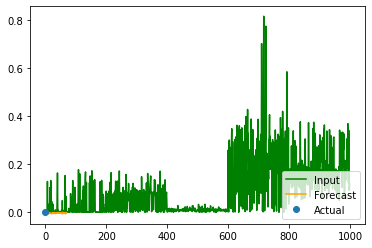

In [13]:
# Chart 1 sample dataset
sample = 0
#plt.plot(X_test[sample],"green", label="Input")
plt.plot(X_test[:,sample,0],"green", label="Input")
plt.plot(F[sample],"orange", label="Forecast")
plt.plot(Y_test[sample],"o", label="Actual")
plt.legend(loc="lower right")
plt.show()

# Evaluate results

## Calculate %Correct

In [14]:
# Compare price band
Y_band_list = [] # The 5% price band of the test data
F_band_list = [] # The 5% price band of the forecast data
F_status_list = [] # 1 if the forecast band is matching the test data, 0 otherwise

for i in range(len(Y_test)): 
    # Get the actual band from the dataset file
    Y_band = Y_DF["Y Band"][i]
    Y_band_list.append(Y_band)
    
    # Calculate forecasted average price
    F_from = Y_DF["Y Gap"][i] + 1 # The starting row of the forecast
    F_to = F_from + Y_DF["Y Days"][i] # The last row of the forecast
    F_avg = np.average(F[i][F_from:F_to]) # Get the average of the 4 or 5 numbers between F_from and F_to

    # Calculate the forecasted band 
    F_pct = (F_avg - Y_DF["X Last Price Norm"][i]) / Y_DF["X Last Price Norm"][i]
    F_band = calc_band(F_pct * 100) # Calculate the 5% price band
    F_band_list.append(F_band)

    # Compare the forecasted band with the actual band
    if Y_band == F_band: F_status = 1 
    else: F_status = 0
    F_status_list.append(F_status)
    #print(Y_band, F_band, F_status)

print(sum(F_status_list)) 
# LSTM 2DL 1e	0.07703	204
# LSTM 1K+71	0.07521	195
# LSTM 1K+1K	0.07552	201
# LSTM 3DL	    0.04281	170
# LSTM 2DL 3e	0.05970	187
# LSTM 2DL 1e	0.06742	195
# LSTM 2DL 2DO=0.1	0.06606	195
# LSTM 2DL 2do 5e 198
# LSTM 2DL MAE 179
# LSTM 2DL CS  122
# LSTM 2DL MSE DO=0.1  139
# LSTM 2DL MSE DO=0.3  193
# LSTM 2DL MSE DO=0.2 1e 131
# LSTM 2DL 1K+71 MSE DO=0.2 3e 141
# LSTM 2DL 71+71 MSE 1DO 3e 200
# LSTM 2DL 71+71 MSE 1DO 3e 137

137


In [15]:
print(X_test[0])
print(Y_test[0])
print(F[0][-5:])
print(Y_DF["Y Gap"][0], Y_DF["Y Days"][0], F[0][66:71], np.average(F[0][66:71]))
print(F_band_list[0], Y_band_list[0], F_status_list[0])

[[0.00169433 0.02897472]
 [0.00168816 0.02399469]
 [0.00169433 0.01450396]
 ...
 [0.00239118 0.02253238]
 [0.00235418 0.0397331 ]
 [0.00234801 0.01607494]]
0.0023979612733380485
[-0.00474137 -0.00641365 -0.00277274 -0.00344946 -0.00214596]
65 5 [-0.00474137 -0.00641365 -0.00277274 -0.00344946 -0.00214596] -0.0039046383
D5 U1 0


## Calculate MCC

In [16]:
# Calculate MCC
Y_forecast = F_band_list
Y_actual   = Y_band_list

matthews_corrcoef(Y_actual, Y_forecast) 
# 2DL 71+71 0.0770279839200202
# 2DL 1000+71 0.07521488721078572
# 2DL 1K+1K 0.07552445980592733
# 3DL 1K,1K,71 0.04281198524695562
# 2DL 71+71, 3 epochs 0.05969887607910092
# 2DL 71+71, 1 epoch 0.06742372142108988
# 2DL 71+71 2DO,  1 epoch 0.06605665992418083
# 2DL 71+71 2DO, 5 epochs 0.06856394850324002
# 2DL 71+71 MAE,  1 epoch 0.04758711658859239
# 2DL 71+71 CS,   1 epoch 0.023604391645571907
# 2DL 71+71 MAPE, 1 epoch 0.03823442826301294
# 2DL 71+71 MSE, 0.1 DO, 1e 0.03738331640235763
# 2DL 71+71 MSE, 0.3 DO, 1e 0.0669592411884038
# 2DL 71+71 MSE, 0.2 DO, 1e 0.02278893150249085
# 2DL 1K+71 MSE, 0.2 DO, 3e 0.03284843039377701
# 2DL 1K+71 MSE, 1 DO, 3e 0.06793917320486068
# 2DL 1K+71 MSE, 1 DO, 3e 0.03501162418572208

0.03501162418572208

## Distribution of the 10 classes

In [17]:
# Distribution of actual data
counter=collections.Counter(Y_band_list)
pprint(dict(counter))

{'D1': 120,
 'D2': 97,
 'D3': 67,
 'D4': 42,
 'D5': 67,
 'U1': 127,
 'U2': 121,
 'U3': 92,
 'U4': 81,
 'U5': 186}


# Save to output file

In [18]:
output_file   = ""
for i in range(len(Y_band_list)):
    output = Y_band_list[i] + "," +  F_band_list[i] + "," + str(F_status_list[i]) + "\n"
    output_file = output_file + output   

In [19]:
# print(output_file)
file_path = "/content/drive/My Drive/Colab Notebooks/3. Code/3. Compare/Output/"
f = open(file_path + "LSTM - 71+71B.csv", "w")
f.write(output_file)
f.close()